In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../dependencies')

    
import pandas as pd
import numpy as np
#import xarray as xr
from dscore import mse, stl, quantiles, seasons, bias_variability
from dscore import ilamb_score, scorecard_plot

In [2]:
import zipfile
from glob import glob

data_path = '../evaluation/example_data/'


# extract data
for f in glob(data_path + '*.zip'):
    with zipfile.ZipFile(f, 'r') as archive:
        #extract to notebook directory, or else set path=data_path
        archive.extractall(path='.') 


def load_csv(filename):
    '''Helper function to load csv data
    '''
    df = pd.read_csv(filename)
    df[['group','date','location']] =  df['Unnamed: 0'].str.split(':', expand=True)
    df = df.drop('Unnamed: 0', axis=1)

    return df


In [3]:
# load streamflow
df = load_csv('01473000.prior.csv')
data = df[df['group'] =='streamflow_mon']

data.head()

,modelled,measured,group,weight,standard_deviation,date,location
163460,13.37580,25.2581,streamflow_mon,4.140187,2.525806,2000_10,01472198
163461,12.72870,14.8774,streamflow_mon,7.028982,1.487742,2000_10,01472199
163462,6.79156,61.7742,streamflow_mon,0.000000,6.177419,2000_10,01472620
163463,50.88440,82.7419,streamflow_mon,1.263846,8.274194,2000_10,01472810
163464,195.41500,192.8060,streamflow_mon,0.542373,19.280646,2000_10,01473000


In [4]:
def compute_objective(data, obs, sim, objective, additive=True):
    '''Helper function to compute objective for each location
    '''
    groupby = 'location'
    scores = {
        'total' :  data.groupby(groupby).apply(lambda x: objective(x[obs], x[sim])),
        'bias-variance' : data.groupby(groupby).apply(lambda x: bias_variability(x[obs], x[sim],  objective=objective, additive=additive)),
        'quantiles' :  data.groupby(groupby).apply(lambda x: quantiles(x[obs], x[sim], objective=objective, additive=additive))
    }
        
    return pd.concat(scores, axis=1)

In [5]:
# streamflow analysis
log_data = data.copy()

# preprocessing
# clip negative values and transform to log
cols = ['modelled','measured']
log_data[cols] = np.log(data[cols].clip(lower=0.01))

log_data


,modelled,measured,group,weight,standard_deviation,date,location
163460,2.593447,3.229147,streamflow_mon,4.140187,2.525806,2000_10,01472198
163461,2.543859,2.699843,streamflow_mon,7.028982,1.487742,2000_10,01472199
163462,1.915681,4.123486,streamflow_mon,0.000000,6.177419,2000_10,01472620
163463,3.929556,4.415726,streamflow_mon,1.263846,8.274194,2000_10,01472810
163464,5.275126,5.261685,streamflow_mon,0.542373,19.280646,2000_10,01473000
...,...,...,...,...,...,...,...
164115,4.424112,2.744941,streamflow_mon,6.719053,1.556367,2010_9,01472198
164116,3.968936,2.389377,streamflow_mon,9.587999,1.090667,2010_9,01472199
164117,2.775266,3.605859,streamflow_mon,0.000000,3.681333,2010_9,01472620
164118,4.715064,3.947519,streamflow_mon,2.018526,5.180667,2010_9,01472810


In [6]:
# compute the objective and save results
streamflow_msle = compute_objective( log_data, 'measured', 'modelled', objective=mse)
streamflow_msle.to_csv("streamflow_msle.csv")

streamflow_msle.head()

total bias-variance             quantiles                      \
               MSE          bias variability       low below_avg above_avg   
location                                                                     
01472198  0.231191      0.085910    0.145281  0.099772  0.054486  0.042699   
01472199  0.121899      0.006614    0.115285  0.062720  0.033309  0.016583   
01472620  1.712619      0.942527    0.770092  0.144728  0.163243  0.362003   
01472810  0.269496      0.064154    0.205342  0.145097  0.060035  0.039159   
01473000  0.163015      0.015054    0.147961  0.077467  0.031774  0.024180   

                    
              high  
location            
01472198  0.034234  
01472199  0.009287  
01472620  1.042645  
01472810  0.025204  
01473000  0.029594

In [7]:
# post-processing
# work from the saved results to produce figures

# here we define some scoring functions
from dscore import ilamb_score

def percentage_score(df, name, total_col='total'):
    score = round(df/df['total'].values * 100).astype(int)
    score.name = name
    
    if isinstance(score, pd.Series):
        score = score.to_frame()
        
    return score

In [8]:
# compute score by location
score = percentage_score(streamflow_msle,  name='NHM')
score

total bias-variance             quantiles                         
           MSE          bias variability       low below_avg above_avg high
location                                                                   
01472198   100            37          63        43        24        18   15
01472199   100             5          95        51        27        14    8
01472620   100            55          45         8        10        21   61
01472810   100            24          76        54        22        15    9
01473000   100             9          91        48        19        15   18

<Axes: ylabel='Component'>

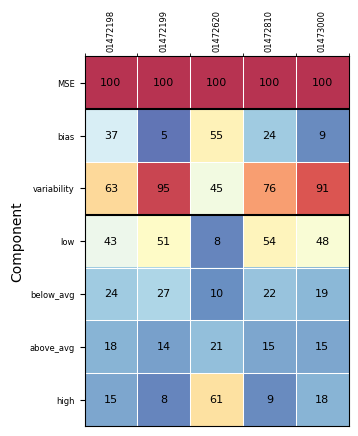

In [9]:
# scorecard by location
scorecard_plot(score.transpose(), cmap='RdYlBu_r')

<Axes: ylabel='Component'>

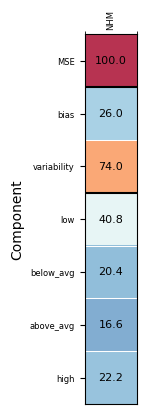

In [10]:
# total score (here each column of the card could be a different model)
scorecard_plot(score.mean().to_frame(name='NHM'), cmap='RdYlBu_r')

## ILAMB style score
Use additive = false here

In [11]:
streamflow_msle = compute_objective( log_data, 'measured', 'modelled', objective=mse, additive=False)

In [12]:
def ilamb_score(df, name, a=1, total_col='total'):
    score = np.exp(-1 * a * df)
    score = round(score * 100).astype(int)
    score.name = name

    if isinstance(score, pd.Series):
        score = score.to_frame()
        
    return score

In [13]:
streamflow_msle

total bias-variance             quantiles                      \
               MSE          bias variability       low below_avg above_avg   
location                                                                     
01472198  0.231191      0.171819    0.290562  0.399089  0.217943  0.170795   
01472199  0.121899      0.013229    0.230569  0.250879  0.133237  0.066333   
01472620  1.712619      1.885055    1.540183  0.578910  0.652973  1.448014   
01472810  0.269496      0.128308    0.410683  0.580389  0.240140  0.156637   
01473000  0.163015      0.030107    0.295923  0.309869  0.127096  0.096719   

                    
              high  
location            
01472198  0.136935  
01472199  0.037147  
01472620  4.170579  
01472810  0.100817  
01473000  0.118376

In [14]:
var = log_data['measured'].var()

# normalize the data then score
score = ilamb_score(streamflow_msle/var, a=3, name='NHM')
score

total bias-variance             quantiles                         
           MSE          bias variability       low below_avg above_avg high
location                                                                   
01472198    59            68          52        41        61        68   73
01472199    76            97          59        57        74        86   92
01472620     2             1           3        27        23         4    0
01472810    54            75          40        27        58        70   80
01473000    69            93          51        50        75        80   77

<Axes: ylabel='Component'>

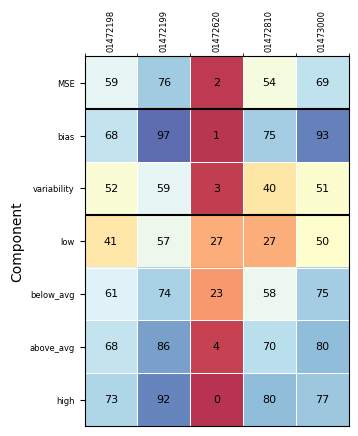

In [15]:
# yuck; technically you can plot this but I don't see this as too useful. I prefer maps here
scorecard_plot(score.transpose())

<Axes: ylabel='Component'>

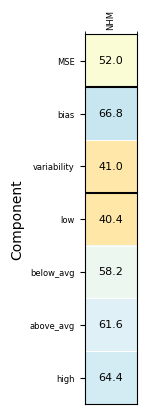

In [37]:
scorecard_plot(score.mean().to_frame(name='NHM'))

## Google style TBD

original units (or standardized units) w/ scaled colors

I'll use MSE and RMSE for clarity, but this is bad practice for streamflow.

In [50]:

streamflow_mse = compute_objective( data, 'measured', 'modelled', objective=mse, additive=False)
streamflow_rmse = np.sqrt(streamflow_mse)
streamflow_rmse

total bias-variance               quantiles              \
                 MSE          bias variability         low   below_avg   
location                                                                 
01472198   23.378866     18.602914   27.332660   14.884810   17.382249   
01472199   11.199739      3.327110   15.485433    8.193539   10.257334   
01472620   25.471683     25.885957   25.050559    8.052568   10.521913   
01472810   48.148803     35.250439   58.258226   27.947683   32.965803   
01473000  181.560593     88.592916  240.997496  101.593760  113.270027   

                                  
           above_avg        high  
location                          
01472198   22.731152   33.850850  
01472199   10.449540   14.839028  
01472620   17.182320   46.091646  
01472810   42.522705   74.814645  
01473000  128.109566  303.798525

In [51]:
streamflow_rmse.mean()

total          MSE            57.951937
bias-variance  bias           34.331867
               variability    73.424875
quantiles      low            32.134472
               below_avg      36.879465
               above_avg      44.199057
               high           94.678939
dtype: float64